## Load packages

In [136]:
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

## Load and show data

### Matrices


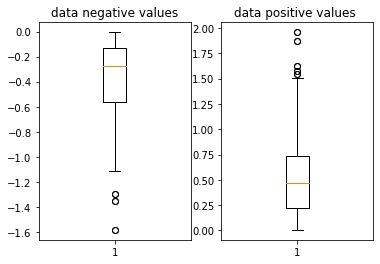

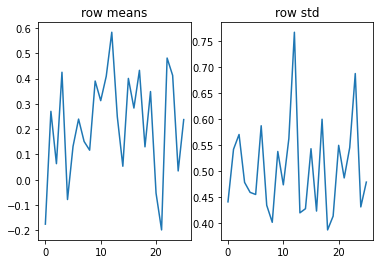

<Figure size 432x288 with 0 Axes>

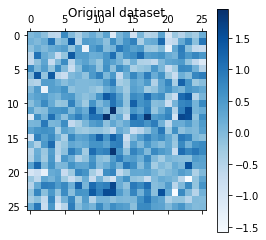

In [137]:
# Load CSV files
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

# Seeing if negative data have same order of magnitude as positive data 
def orderOfMagnitude(matrix):
    for i in range(len(matrix)):
        matrix[i,i] = 0
    
    neg = matrix[matrix<0]
    plt.subplot(121)
    plt.boxplot(neg)
    plt.title("data negative values")
    
    pos = matrix[matrix>0]
    plt.subplot(122)
    plt.boxplot(pos)
    plt.title("data positive values ")
    
# Remove outlier in array if we find one
def removeOutlierArray(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    new_mat = np.delete(new_mat, (subject), axis=1)
    
    with open(os.path.join('ISC_truncated.csv'), 'w') as File:
        writer = csv.writer(File)
        writer.writerows(matrix)
    
    return new_mat

# Remove outlier in vector if we find one
def removeOutlierVector(vector,subject):
    new_vect = np.copy(vector)
    new_vect = np.delete(new_vect, (subject), axis=0)
    return new_vect

'''
# Remove outliers everywhere
def removeOutlier(matrix,condition,subject):
    removeOutlierArray(matrix,subject)
    removeOutlierVector(condition,subject)
'''
    
# Remove Inf in data for EDA and IBI (replace by sort of normalisation for the moment)
tmp = np.copy(ISC_EEG)
for i in range(len(tmp)):
    tmp[i,i] = 0
eegNorm = 3/np.mean(tmp)

for i in range(len(ISC_IBI)):
    ISC_IBI[i,i] = np.mean(ISC_IBI)*eegNorm
    ISC_EDA[i,i] = np.mean(ISC_EDA)*eegNorm
    
# Choose matrix to study
case = 'EDA'
removeOutlier = False # Remove outliers if there are some

if (case == 'EEG'):
    if (removeOutlier): # Remove outliers if there are some
        ISC_EEG = removeOutlierArray(ISC_EEG,3) # Really outlier?
    study_matrix = ISC_EEG
elif (case == 'EDA'):
    if (removeOutlier): # Remove outliers if there are some
        #ISC_EDA = removeOutlierArray(ISC_EDA,12) # Really outlier?
        #ISC_EDA = removeOutlierArray(ISC_EDA,20) # Really outlier?
        ISC_EDA = removeOutlierArray(ISC_EDA,17)
    study_matrix = ISC_EDA
elif (case == 'IBI'):
    if (removeOutlier): # Remove outliers if there are some
        print("Haven't found any outliers for the moment")
        # ISC_IBI = removeOutlierArray(ISC_IBI,)
    study_matrix = ISC_IBI

N = len(study_matrix)

# Boxplot
orderOfMagnitude(np.copy(study_matrix))

# Normalize rows and columns ?
for i in range(len(study_matrix)):
    study_matrix[i,i] = 0
    
# Remove negative values from EDA and IBI
#study_matrix = np.where(study_matrix>0,study_matrix,0)

plt.figure()
plt.subplot(121)
plt.plot(np.mean(study_matrix,axis=0))
plt.title('row means')
plt.subplot(122)
plt.plot(np.std(study_matrix,axis=0))
plt.title('row std')

# Show matrix data
plt.figure()
plt.matshow(study_matrix, cmap=plt.cm.Blues)
plt.title("Original dataset")
plt.colorbar()
plt.show()

### True groups

In [179]:
# Load true clusters
condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
if (removeOutlier): # Remove outliers if there are some
    if (case == 'EEG'):
        condition = removeOutlierVector(condition,3) # Really outlier?
    elif (case == 'EDA'):
        #condition = removeOutlierVector(condition,12) # Really outlier?
        #condition = removeOutlierVector(condition,20) # Really outlier?
        condition = removeOutlierVector(condition,17) # Really outlier?
    elif (case == 'IBI'):
        print("Haven't found any outliers for the moment")
        # condition = removeOutlierVector(condition,) # Really outlier?

narrative = np.where(condition == 0)[0]
stimulus = np.where(condition == 1)[0]

#conditionShuffle = np.random.shuffle(np.copy(condition))
conditionShuffle = np.zeros_like(condition)

### Compute distance matrix

In [139]:
# rank of elements 
def rankify(A): 
  
    # Rank Vector 
    R = [0 for x in range(len(A))] 
  
    # Sweep through all elements 
    # in A for each element count 
    # the number of less than and  
    # equal elements separately 
    # in r and s. 
    for i in range(len(A)): 
        (r, s) = (1, 1) 
        for j in range(len(A)): 
            if j != i and A[j] < A[i]: 
                r += 1
            if j != i and A[j] == A[i]: 
                s += 1       
         
        # Use formula to obtain rank 
        R[i] = r + (s - 1) / 2
  
    # Return Rank Vector 
    return R

In [140]:
import scipy.spatial.distance as ssd

def computeDistanceMatrix(normalisation=1,addCoef=0,uncondensed=False,euclideanTransform=True,finalNorm=False,rank=False): # Choose normalisation between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1
    # Change matrix diagonal value (kind of normalisation)
    matrix_norm = np.copy(study_matrix)
    for i in range(len(matrix_norm)):
        matrix_norm[i,i] = 0
    maxi = np.max(abs(matrix_norm)) # Max value except from the diagonal

    for i in range(len(matrix_norm)):
        #matrix_norm[i,i] = maxi
        matrix_norm[i,i] = np.max(study_matrix)/normalisation

    # Normalise max value to 1
    matrix_norm = matrix_norm / np.max(abs(matrix_norm))

    # Compute distance matrix
    if (euclideanTransform):
        distance_matrix = np.sqrt(2*N*(1-matrix_norm))
    else:
        distance_matrix = 1-matrix_norm
    
    # Normalisation to avoid negative eigen values in PCoA
    distance_matrix = distance_matrix + addCoef
    for i in range(len(study_matrix)):
        distance_matrix[i,i] = 0
    
    # Transform matrix into uncondensed matrix
    if (uncondensed):
        # convert the redundant n*n square matrix form into a condensed nC2 array
        distance_matrix = ssd.squareform(distance_matrix)
        
    # Transform matrix into rank matrix
    if (rank):
        rank_matrix = np.zeros_like(distance_matrix)
        for i in range(N):
            rank_matrix[i,:] = rankify(distance_matrix[i,:])
        return rank_matrix
        
    ## Write new CSV file with all data
    if (uncondensed==False):
        with open(os.path.join('dist_'+ case + '.csv'), 'w') as File:
            writer = csv.writer(File)
            writer.writerows(distance_matrix)
            
    if (finalNorm):
        distance_matrix = distance_matrix / np.std(distance_matrix) 

    return distance_matrix
    
'''
# Normalise data
for i in range(len(matrix)):
    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])
'''

'\n# Normalise data\nfor i in range(len(matrix)):\n    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])\n'

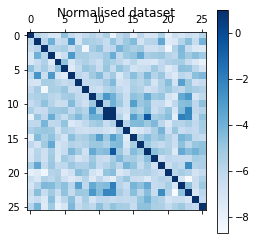

In [141]:
norm_coef = 1
add_coef = 0
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef) # Choose between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1
study_matrix_norm = 1-(distance_matrix-add_coef)
for i in range(len(study_matrix)):
    study_matrix_norm[i,i] = 1

plt.matshow(study_matrix_norm, cmap=plt.cm.Blues)
plt.title("Normalised dataset")
plt.colorbar()
plt.show()

### Silhouette coefficient (SC)

In [142]:
from sklearn.metrics import silhouette_score

# Compute DB-score based on distance matrix(small means good clustering)
def silhouetteCoef(distance_matrix,label,metric='precomputed'):
    return silhouette_score(distance_matrix, label, metric=metric)

accuracyVect = np.array([])
SCVect = np.array([])
methodUsed = np.array([])
prior = np.array([])

## Bloc modelling / Bi-clustering

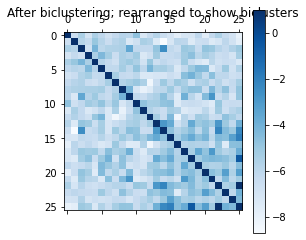

In [143]:
from sklearn.cluster import SpectralCoclustering

# Fit the model
cocluster = SpectralCoclustering(n_clusters=2, random_state=0)
cocluster.fit(study_matrix_norm)
'''
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.3f}".format(score))
'''
fit_data = study_matrix_norm[np.argsort(cocluster.row_labels_)]
fit_data = fit_data[:, np.argsort(cocluster.column_labels_)]

# Show results
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.colorbar()
plt.show()

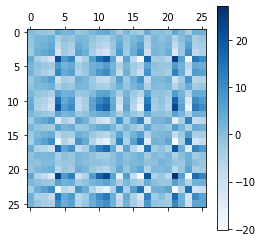

In [144]:
# Show matrix inverse (decorrelation?)
decorr = np.linalg.inv(study_matrix)

plt.matshow(decorr, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

## Defining result class

In [180]:
from sklearn.metrics import davies_bouldin_score,adjusted_rand_score

class Results():

    def __init__(self,name,random_init,sslLabel=None):
        self.accuracy = np.zeros((int(N/4)+1,len(coefficients)))
        self.best_accuracy = 0
        self.best_dim = 0
        self.best_norm = 0
        self.label = np.zeros(N)
        self.probaLabel = np.zeros(N)
        self.wellClassified = None
        self.wrongClassified = None
        self.name = name
        self.random_init = random_init
        self.best_points = None
        self.SC = -1
        self.sslLabel = sslLabel
        
    def thresholdLabel(self):
        self.label = np.where(self.probaLabel<0.5,0,1)
    
    def initCenters(self,NA_ref,SSA_ref,points):
        dim = points.shape[1]
        init = np.zeros((dim,2))
        init[:,0] = np.mean(points[NA_ref,:],axis=0)
        init[:,1] = np.mean(points[SSA_ref,:],axis=0)
        return init.T
        
    def twoClustersMethodResult(self):
        print("Results\n")
        if (random_init==False):
            print("Best dimension %d (7 means t-SNE)" %self.best_dim)
            print("Best normalisation %d " %self.best_norm)
        print("Found clusters ")
        print(self.label)
        print("True clusters ")
        print(condition)
        self.trueWrongClusters(self.label,condition)
        print("Well classified")
        print(self.wellClassified)
        print("Wrong classified")
        print(self.wrongClassified)
        self.best_accuracy = np.max(self.accuracy)
        print("Best %s accuracy : %f" %(self.name,self.best_accuracy))
        print("Silhouette coefficient : %0.3f" %self.SC)
        if (self.random_init):
            self.findRobustParticipants()
        
    def trueWrongClusters(self,label,condition):
        subjects = np.arange(0,N)
        self.wellClassified = subjects[label==condition]
        self.wrongClassified = subjects[label!=condition]
        
    def findRobustParticipants(self):
        robustness = 0.7
        self.robustLabel = np.where((self.probaLabel<=(1-robustness))+(self.probaLabel>=robustness),1,0)
        print("Robust participants")
        print(self.robustLabel)
        print(subjects[self.robustLabel==1])
        print("Frequencies")
        print(self.probaLabel)
        
    def applyMethod(self,method,dim=np.arange(1,int(N/4)+2)):
        print("Computing clustering\n")
        for p in range(len(coefficients)):
            print(str(int(p*100/len(coefficients))) + "%")
            distance_matrix = computeDistanceMatrix(normalisation=coefficients[p],addCoef=add_coef)

            for i in dim: # Negative means PCoA, 7 means t-SNE, range(1,6) means metric MDS
                self.best_points = np.zeros((N,i))
                if (isinstance(self,MapMethodResults)):
                    if (i<0):
                        points = computePCoACoordinate(distance_matrix,n_comp=abs(i))
                    if (i<int(N/4)+1):
                        points,stress = computeMDSCoordinate(distance_matrix,i)
                    else:
                        points = computeSNECoordinate(distance_matrix)
                    if hasattr(method, 'init'):
                        if hasattr(method.init, 'shape'):
                            method.init = self.initCenters(NA_HC,SSA_HC,points)
                    if (self.sslLabel is None):
                        meth = method.fit(points)
                    else:
                        meth = method.fit(points,self.sslLabel)
                else:
                    meth = method.fit(distance_matrix)
                    
                if hasattr(meth, 'labels_'):
                    label = meth.labels_
                else:
                    label = meth.predict(points)
                
                acc = sum(condition==label)/N
                if (acc<0.5):
                    label = 1-label
                    self.accuracy[i-1,p] = 1-acc
                else:
                    self.accuracy[i-1,p] = acc
                
                if self.accuracy[i-1,p] == np.max(self.accuracy):
                    self.label = label
                    self.best_dim = i
                    self.best_norm = coefficients[p]
                    if (isinstance(self,MapMethodResults)):
                        self.best_points = points
                        self.SC = silhouetteCoef(self.best_points,self.label,metric='euclidean')
                    else:
                        self.SC = silhouetteCoef(distance_matrix,self.label,metric='precomputed')
        
    def applyMethodAverage(self,method,coef,dim=2,n_run=1,verbose=True):
        print("Computing clustering\n")
        self.best_points = np.zeros((N,dim))
        self.best_dim = dim
        distance_matrix = computeDistanceMatrix(normalisation=coef,addCoef=add_coef)
        for k in range(n_run):
            if (verbose):
                print(str(int(k*100/n_run)) + "%")
            if (isinstance(self,MapMethodResults)):
                if (dim<int(N/4)+1):
                    points = computePCoACoordinate(distance_matrix,n_comp=dim)
                else:
                    points = computeSNECoordinate(distance_matrix)
                if hasattr(method, 'init'):
                    if hasattr(method.init, 'shape'):
                        method.init = self.initCenters(NA_HC,SSA_HC,points)
                meth = method.fit(points)
            else:
                meth = method.fit(distance_matrix)

            if hasattr(meth, 'labels_'):
                label = meth.labels_
            else:
                label = meth.predict(points)
            label = np.array(label,dtype='float64')

            acc = sum(condition==label)/N
            if (acc<0.5):
                label = 1-label
            self.probaLabel += label/n_run
        self.thresholdLabel()
        if (isinstance(self,MapMethodResults)):
            self.best_points = points
            self.SC += silhouetteCoef(self.best_points,self.label,metric='euclidean')/n_run
        else:
            self.SC = silhouetteCoef(distance_matrix,self.label,metric='precomputed')/n_run

        acc = sum(condition==self.label)/N
        if (acc<0.5):
            self.accuracy[0,0] = 1-acc
        else:
            self.accuracy[0,0] = acc
            
    def writeProbaLabel(self):
        probaLabel = np.zeros((N,2))
        probaLabel[:,0] = condition
        probaLabel[:,1] = self.probaLabel
        with open(os.path.join('probaClustering_' + case + '_dim' + str(self.best_dim) + '_' + self.name + '.csv'), 'w') as File:
            writer = csv.writer(File)
            writer.writerows(probaLabel)
            
class DistanceMethodResults(Results):
    
    def __init__(self,name,random_init):
        Results.__init__(self,name,random_init)
        
class MapMethodResults(Results):
    
    def __init__(self,name,random_init,sslLabel=None):
        Results.__init__(self,name,random_init,sslLabel)
        
    def applyMethodAndMDSAverages(self,method,dim=2,coef=1,n_run=1,n_mds_run=1,verbose=True):
        print("Computing clustering\n")
        self.best_points = np.zeros((N,dim))
        self.best_dim = dim
        distance_matrix = computeDistanceMatrix(normalisation=coef,addCoef=add_coef)
        for i in range(n_mds_run):
            if (verbose):
                print(str(int(i*100/n_mds_run)) + "%")
            for k in range(n_run):
                if (isinstance(self,MapMethodResults)):
                    points,stress = computeMDSCoordinate(distance_matrix,dim)
                    if (self.sslLabel is None):
                        meth = method.fit(points)
                    else:
                        meth = method.fit(points,self.sslLabel)
                else:
                    meth = method.fit(distance_matrix)
                
                if hasattr(meth, 'labels_'):
                    label = meth.labels_
                else:
                    label = meth.predict(points)
                label = np.array(label,dtype='float64')

                acc = sum(condition==label)/N
                accShuffle = sum(conditionShuffle==label)/N
                if (acc<0.5):
                    label = 1-label
                self.probaLabel += label/(n_run*n_mds_run)
            self.best_points += points
        self.thresholdLabel()
        self.SC = silhouetteCoef(self.best_points,self.label,metric='euclidean')

        acc = sum(condition==self.label)/N
        if (acc<0.5):
            self.accuracy[0,0] = 1-acc
        else:
            self.accuracy[0,0] = acc
        
    def clusteringAccuracyWithDimension(self):
        # Plot clustering accuracy with increasing dimension
        for p in range(len(coefficients)):
            plt.plot(np.arange(1,int(N/4)+2),self.accuracy[:,p],label=str(coefficients[p]))
        plt.xlabel("number of mds dimensions")
        plt.ylabel("%s accuracy" %self.name)
        plt.legend()
        
    def showResultMap(self):
        plt.figure()
        
        if (self.best_dim != 1):
            ax = plt.axes([0,0,1.2,1.2])
            ax.set_aspect(aspect='equal')
            for i in range(N):
                if (i in self.wellClassified):
                    if (condition[i] == 0):
                        color = 'blue'
                        label = 'NA'
                    else:
                        color = 'red'
                        label = 'SSA'
                else:
                    color = 'black'
                    label = 'misclassified'
                ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+np.max(self.best_points)/20,self.best_points[i,1]))
                ax.scatter(self.best_points[i,0],self.best_points[i,1],color=color,s=145,label=label)
        else:
            plt.scatter(self.best_points[narrative],np.zeros((len(narrative),1)),marker='x',color='blue')
            plt.scatter(self.best_points[stimulus],np.zeros((len(stimulus),1)),marker='x',color='red')
            orderedSubjectPlot = np.argsort(self.best_points.T)
            for i in range(len(condition)):
                subj = orderedSubjectPlot[0,i]
                plt.annotate(subj,(self.best_points[subj,0],0),xytext=(self.best_points[subj,0]-((i+1)%2+1)*np.max(self.best_points)/35,0.01*(i%2)-0.0065))
    
        TP = mpatches.Patch(color='blue', label='NA')
        TN = mpatches.Patch(color='red', label='SSA')
        FP_FN = mpatches.Patch(color='black', label='misclassified')
        plt.legend(handles=[TP,TN,FP_FN])
        plt.title("%s clustering" %self.name)
        
    def dbScore(self):
        # Compute DB-score (small means good clustering)
        return davies_bouldin_score(self.best_points,self.label)

In [146]:
# from ResultClass import Results

random_init = True # MDS with several random init
nRun = 4000 # Number of runs with different random init if random_init True

## Hierarchical clustering

### Hierarchical clustering based on correlation (diagonal normalised)

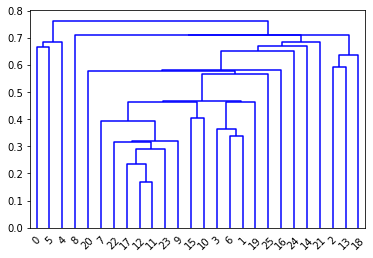

In [147]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z=linkage(study_matrix_norm,'single','correlation',optimal_ordering=True)
dendrogram(Z, color_threshold=0)
plt.show()

In [148]:
print("group 0 (NA) : ",narrative)
print("group 1 (SSA): ",stimulus)

group 0 (NA) :  [ 0  2  4  5  7  9 11 13 16 17 18 22 25]
group 1 (SSA):  [ 1  3  6  8 10 12 14 15 19 20 21 23 24]


### Hierarchical clustering based on euclidean distance

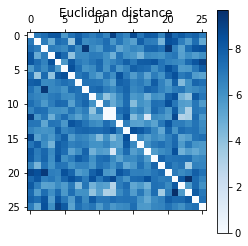

In [149]:
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
plt.matshow(distance_matrix, cmap=plt.cm.Blues)
plt.title("Euclidean distance")
plt.colorbar()
plt.show()

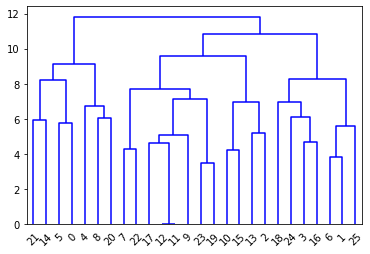

Found clusters 
[ 3 23 17 18  6  2 22  7  4 11 14  9  9 16  1 15 19 10 21 13  5  0  8 12
 20 24]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[14]
Wrong classified
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25]
Accuracy : 0.038462
Silhouette coefficient : 0.077


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [150]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef,uncondensed=True)
Z=linkage(distance_matrix,'ward','euclidean',optimal_ordering=True)
threshold = 4-0.2*(case=='EEG') # 3.8 EEG, 4 EDA, 4 IBI if add_coef ==2
threshold = 1.5*(case!='EDA') # 1.4 or 1.5 EEG, 4 EDA, 4 IBI if no normalisation
#threshold = 3.55
dendrogram(Z, color_threshold=threshold)
plt.show()

print("Found clusters ")
label = (fcluster(Z, t=threshold, criterion='distance')-1)
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_HC = subjects[label==1] # Maybe NA
NA_HC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
#[ 0  2  3  7  8 10 16 18 25]
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'HC' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'HC')
    prior = np.append(prior,'dist')

In [151]:
'''
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="precomputed",linkage='single').fit(distance_matrix)
plot_dendrogram(clustering)

print("Found clusters ")
label = clustering.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_HC = subjects[label==1] # Maybe NA
NA_HC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
#[ 0  2  3  7  8 10 16 18 25]
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
'''

'\nfrom sklearn.cluster import AgglomerativeClustering\n\ndef plot_dendrogram(model, **kwargs):\n    # Create linkage matrix and then plot the dendrogram\n\n    # create the counts of samples under each node\n    counts = np.zeros(model.children_.shape[0])\n    n_samples = len(model.labels_)\n    for i, merge in enumerate(model.children_):\n        current_count = 0\n        for child_idx in merge:\n            if child_idx < n_samples:\n                current_count += 1  # leaf node\n            else:\n                current_count += counts[child_idx - n_samples]\n        counts[i] = current_count\n\n    linkage_matrix = np.column_stack([model.children_, model.distances_,\n                                      counts]).astype(float)\n    \n    # Plot the corresponding dendrogram\n    dendrogram(linkage_matrix, **kwargs)\n\ndistance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)\nclustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None,affinity="precompu

## Affinity propagation

In [152]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(affinity="precomputed").fit(distance_matrix)
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
print('Estimated number of clusters: %d' % n_clusters_)

print("Found clusters ")
label = af.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_aff = subjects[label==1] # Maybe NA
NA_aff = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
n_clusters_ = len(cluster_centers_indices)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'affinity' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'affinity')
    prior = np.append(prior,'dist')

Estimated number of clusters: 4
Found clusters 
[2 2 2 0 0 2 3 3 1 3 2 3 3 2 1 1 1 3 0 2 2 3 3 3 0 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 4  8 14 15 18 25]
Wrong classified
[ 0  1  2  3  5  6  7  9 10 11 12 13 16 17 19 20 21 22 23 24]
Accuracy : 0.230769
Silhouette coefficient : -0.025


## K-Medoids 
robust with noisy data -> "Performance Analysis Of K-Means And K-Medoids Clustering Algorithms For A Randomly Generated Data Set"

In [153]:
from KMedoidsPaper import KMedoids

# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

kmedoids_result = DistanceMethodResults("k-medoids",random_init)
if (random_init): # Several runs with different random init
    kmedoids = KMedoids(n_clusters=2,tmax=100)
    kmedoids_result.applyMethodAverage(kmedoids,coef=norm_coef,n_run=nRun,verbose=False) # 2D max I think, otherwise curse of dimensionnality
else: # one run with HC results for init
    kmedoids = KMedoids(n_clusters=2,tmax=100,init=[NA_HC,SSA_HC]) # init array used before fit
    kmedoids_result.applyMethodAverage(kmedoids,coef=norm_coef) # 2D max I think, otherwise curse of dimensionnality
    
# Show results
kmedoids_result.twoClustersMethodResult()
if 'k-medoids' not in methodUsed:
    accuracyVect = np.append(accuracyVect,kmedoids_result.best_accuracy)
    SCVect = np.append(SCVect,kmedoids_result.SC)
    methodUsed = np.append(methodUsed,'k-medoids')
    prior = np.append(prior,'dist')

Computing clustering

Results

Found clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24]
Wrong classified
[12 25]
Best k-medoids accuracy : 0.923077
Silhouette coefficient : 0.000
Robust participants
[0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 3 5 6]
Frequencies
[0.4615  0.7295  0.3185  0.7285  0.323   0.2915  0.7485  0.4365  0.613
 0.3965  0.54975 0.37375 0.48975 0.33475 0.59925 0.54    0.44875 0.4895
 0.489   0.685   0.52375 0.5315  0.3635  0.51125 0.63475 0.6255 ]


## Spectral clustering (precomputed -> distance matrix)

In [154]:
'''
from sklearn.cluster import SpectralClustering

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
clustering = SpectralClustering(n_clusters=2, n_init=1000,affinity='precomputed').fit(distance_matrix)
print("Found clusters ")
label = clustering.labels_
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_SC = subjects[label==1] # Maybe NA
NA_SC = subjects[label==0] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
accuracy = len(wellClassified)/N
print("Accuracy : %f" %accuracy)
SC = silhouetteCoef(distance_matrix,label)
print("Silhouette coefficient : %0.3f" %SC)
if 'SC_dist' not in methodUsed:
    accuracyVect = np.append(accuracyVect,accuracy)
    SCVect = np.append(SCVect,SC)
    methodUsed = np.append(methodUsed,'SC_dist')
    prior = np.append(prior,'dist')
''' 
    
nRun= 10
    
from sklearn.cluster import SpectralClustering

# coefficients = np.linspace(1,45,2)
coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                    # (2 is ok for that and for only positive eigen values EEG)

clusteringDist_result = DistanceMethodResults("spectral clustering based on distances",random_init)
if (random_init): # Several runs with different random init
    clusteringDist = SpectralClustering(n_clusters=2, n_init=100,affinity='precomputed')
    clusteringDist_result.applyMethodAverage(clusteringDist,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    
    # Show results
    clusteringDist_result.twoClustersMethodResult()
    if 'SC_dist' not in methodUsed:
        accuracyVect = np.append(accuracyVect,clusteringDist_result.best_accuracy)
        SCVect = np.append(SCVect,clusteringDist_result.SC)
        methodUsed = np.append(methodUsed,'SC_dist')
        prior = np.append(prior,'dist')

Computing clustering

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
Results

Found clusters 
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  2  4  5  7  9 11 12 13 16 17 18 22 25]
Wrong classified
[ 1  3  6  8 10 14 15 19 20 21 23 24]
Best spectral clustering based on distances accuracy : 0.538462
Silhouette coefficient : -0.017
Robust participants
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Frequencies
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


## Multi Dimensionnal Scaling

### Modified scikit MDS (because there is no normalised stress) (metric and non-metric)

In [155]:
from MDS_normalized import MDS as MDS_norm
from sklearn import preprocessing

# MDS with normalised stress, distance_matrix must be symmetric in scikit
def computeMDSCoordinate(distance_matrix,n_comp,metric=False,printStress=False,dissimilarity='precomputed',random_state=None,max_iter=300,n_init=4):
    mds = MDS_norm(n_components=n_comp,random_state=random_state,normalize=True,eps=1e-10,metric=metric,dissimilarity=dissimilarity,max_iter=max_iter,n_init=n_init)
    mds.fit(distance_matrix)
    points = mds.embedding_
    stress = mds.stress_
    '''
    Stress-1 that according to Kruskal (1964, p. 3) has more or less 
    the following interpretation: value 0 indicates perfect fit, 
    0.025 excellent, 0.05 good, 0.1 fair and 0.2 poor.
    '''
    if (printStress):
        print("Stress of the method : %f" %stress)
    points = preprocessing.scale(points)
    return points, stress

### Scikit MDS (metric and non-metric)

In [156]:
# Scikit MDS
from sklearn.manifold import MDS

def mdsScikit(n_comp,distance_matrix,dissimilarity='precomputed'):
    mds = MDS(n_components=n_comp,random_state=1,dissimilarity=dissimilarity,eps=1e-10)
    mds.fit(distance_matrix)
    points = mds.embedding_
    stress = mds.stress_

    '''
    # Normalise data
    for i in range(n_comp):
        points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])
    '''
    points = preprocessing.scale(points)
    return points

### Show MDS results

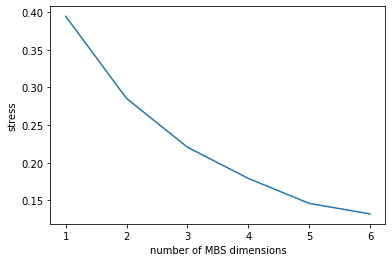

In [157]:
from sklearn.decomposition import PCA

# Make PCA to project MDS data in 2D
def transformPoints(points,n_comp=2):
    if ((points.shape[1] != 2) or (n_comp!=2)):
        # Normalise data
        for i in range(len(points[1,:])):
            points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])

        pca = PCA(n_components=n_comp)
        points = pca.fit_transform(points)
        print("%f variance explained when plotting" %sum(pca.explained_variance_ratio_[:n_comp]))
    return points

# Show MDS scaling
import matplotlib.patches as mpatches

def plotPoints(points,projection=False,title='Ground truth'):
    if (points.shape[1] != 1):
        ax = plt.axes([1.2,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
        if (projection):
            points = transformPoints(points)

        for i in range(len(condition)):
            ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))

        plt.scatter(points[narrative,0],points[narrative,1],color='blue',s=145,label='NA')
        plt.scatter(points[stimulus,0],points[stimulus,1],color='red',s=145,label='SSA')
    else:
        plt.scatter(points[narrative],np.zeros((len(narrative),1)),marker='x',color='blue')
        plt.scatter(points[stimulus],np.zeros((len(stimulus),1)),marker='x',color='red')
        orderedSubjectPlot = np.argsort(points.T)
        for i in range(len(condition)):
            subj = orderedSubjectPlot[0,i]
            plt.annotate(subj,(points[subj,0],0),xytext=(points[subj,0]-((i+1)%2+1)*np.max(points)/35,0.01*(i%2)-0.0065))
        
    NA = mpatches.Patch(color='blue', label='NA')
    SSA = mpatches.Patch(color='red', label='SSA')
    plt.legend(handles=[NA,SSA])
    
    plt.title(title)

# Find best MDS dimension
stress = np.zeros((int(N/4),1)) # dimension rule : dimension < N/4 
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
for i in range(1,int(N/4)+1):
    points,stress[i-1] = computeMDSCoordinate(distance_matrix,i,random_state=1)

plt.plot(np.arange(1,int(N/4)+1),stress)
plt.xlabel("number of MBS dimensions")
plt.ylabel("stress")

# EEG : 6
# EDA : 3 or 4
mdsDim = 6


0.398142 variance explained when plotting
Stress of the method : 0.090732
0.421689 variance explained when plotting
Stress of the method : 0.090928
0.403105 variance explained when plotting


<Figure size 432x288 with 0 Axes>

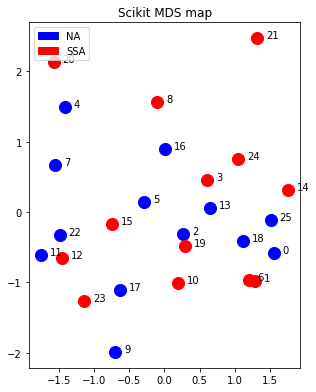

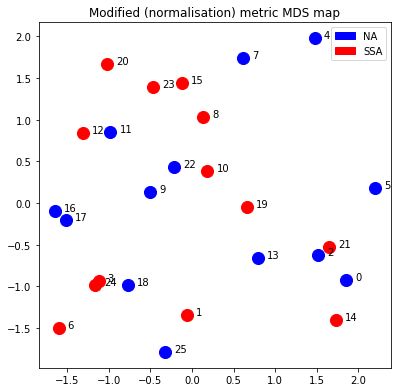

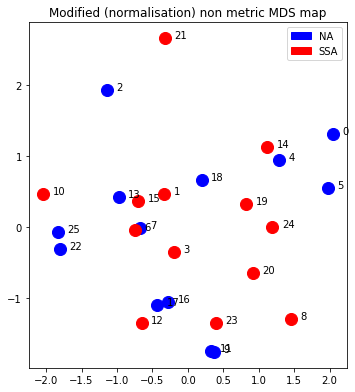

<Figure size 432x288 with 0 Axes>

In [158]:
# MDS with Normalised stress
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=0)
points = mdsScikit(mdsDim,distance_matrix,dissimilarity='precomputed')
plotPoints(points,projection=True,title='Scikit MDS map')
plt.figure()
points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True,max_iter=1000,n_init=10)
plotPoints(points,projection=True,title='Modified (normalisation) metric MDS map')
plt.figure()
points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True,random_state=1,metric=False,max_iter=1000,n_init=10)
plotPoints(points,projection=True,title='Modified (normalisation) non metric MDS map')
plt.figure()
#distance_matrix = computeDistanceMatrix(norm_coef,addCoef=0,rank=True)
#points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True,random_state=1,metric=False,max_iter=1000,n_init=10)
#plotPoints(points,projection=True,title='Modified (normalisation) non metric MDS map on ranked matrix')

## Deterministic PCoA = classical MDS

//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -18.530260164118374 and the largest is 103.66754144205802.
  RuntimeWarning


pcoa proportion explained : 0.2943408159201289 


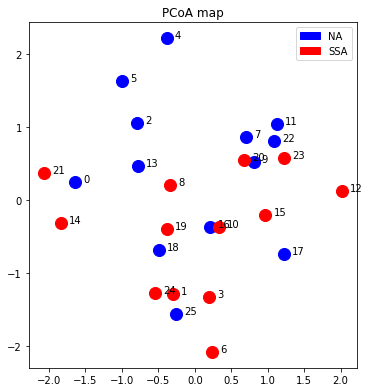

In [159]:
from skbio.stats.ordination import pcoa

def computePCoACoordinate(distance_matrix,n_comp=2):
    
    pcoa_map = pcoa(distance_matrix, method='eigh', number_of_dimensions=n_comp)
    #print(pcoa_map.proportion_explained)
    print("pcoa proportion explained : %s " %np.sum(pcoa_map.proportion_explained))
    #print("eigen values")
    #print(pcoa_map.eigvals)
    points = np.array(pcoa_map.samples)
    points = preprocessing.scale(points)
    return points

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computePCoACoordinate(distance_matrix,2)
points = transformPoints(points)
plotPoints(points,title='PCoA map')

## t-SNE

//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -18.530260164118374 and the largest is 103.66754144205802.
  RuntimeWarning


pcoa proportion explained : 0.2943408159201289 


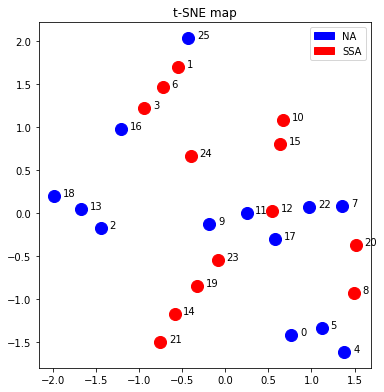

In [160]:
from sklearn.manifold import TSNE

def computeSNECoordinate(distance_matrix,n_pcoa_comp=2,n_tsne_comp=2):
    #points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True)
    pcoa_points = computePCoACoordinate(distance_matrix,n_pcoa_comp)
    points_lessD = transformPoints(pcoa_points,n_tsne_comp)
    tsne = TSNE(n_components=n_tsne_comp, perplexity=4, n_iter=3000,metric="precomputed", init=points_lessD)
    tsne_points = tsne.fit_transform(distance_matrix)
    #tsne_points = transformPoints(tsne_points)
    tsne_points = preprocessing.scale(tsne_points)
    return tsne_points
    
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computeSNECoordinate(distance_matrix)
plotPoints(points,title='t-SNE map')

## LDA

//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -18.530260164118374 and the largest is 103.66754144205802.
  RuntimeWarning
//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -18.53026016

pcoa proportion explained : 0.5930939197233118 
pcoa proportion explained : 0.5930939197233118 
0.200000 variance explained when plotting


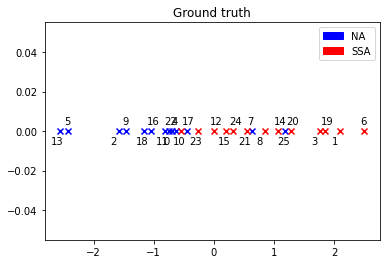

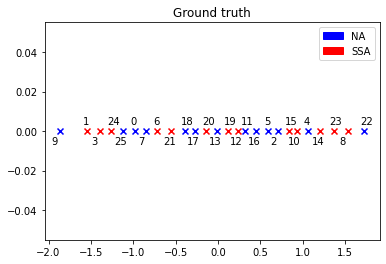

In [161]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

dim = 5
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computePCoACoordinate(distance_matrix,dim)
lda = LinearDiscriminantAnalysis(n_components=1)
points = lda.fit(points, condition).transform(points)
plotPoints(points,'LDA map (not to cluster, just to see data)')

plt.figure()
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computeSNECoordinate(distance_matrix,dim,1)
plotPoints(points,'t-SNE 1D')

## Semi-supervised dimensionnality reduction

### Ivis

In [162]:
'''
from ivis import Ivis

distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True,random_state=1)

# -1 for unlabeled data
try:
    sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)
except:
    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)

model = Ivis(embedding_dims=2,k=4,batch_size=7,epochs=30)
pointsIvis = model.fit_transform(points, sslLabel)
'''

"\nfrom ivis import Ivis\n\ndistance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)\npoints,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True,random_state=1)\n\n# -1 for unlabeled data\ntry:\n    sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)\nexcept:\n    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)\n\nmodel = Ivis(embedding_dims=2,k=4,batch_size=7,epochs=30)\npointsIvis = model.fit_transform(points, sslLabel)\n"

In [163]:
'''
## MDS

plotPoints(points,title='MDS map')

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')

for i in range(len(condition)):
    ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))

plt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')
plt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')
plt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')

NA = mpatches.Patch(color='blue', label='labeled NA')
SSA = mpatches.Patch(color='red', label='labeled SSA')
unlabeled = mpatches.Patch(color='black', label='unlabeled')

plt.legend(handles=[NA,SSA,unlabeled])
plt.title('MDS map')

## Compare to Ivis

plt.figure()
plotPoints(pointsIvis,title='Ivis map')

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')

for i in range(len(condition)):
    ax.annotate(i,(pointsIvis[i,0],pointsIvis[i,1]),xytext=(pointsIvis[i,0]+np.max(pointsIvis)/20,pointsIvis[i,1]))

plt.scatter(pointsIvis[sslLabel==0,0],pointsIvis[sslLabel==0,1],color='blue',s=145,label='NA')
plt.scatter(pointsIvis[sslLabel==1,0],pointsIvis[sslLabel==1,1],color='red',s=145,label='SSA')
plt.scatter(pointsIvis[sslLabel==-1,0],pointsIvis[sslLabel==-1,1],color='black',s=145,label='unlabeled')

NA = mpatches.Patch(color='blue', label='labeled NA')
SSA = mpatches.Patch(color='red', label='labeled SSA')
unlabeled = mpatches.Patch(color='black', label='unlabeled')

plt.legend(handles=[NA,SSA,unlabeled])
plt.title('Ivis map')
'''

"\n## MDS\n\nplotPoints(points,title='MDS map')\n\nax = plt.axes([0,0,1.2,1.2])\nax.set_aspect(aspect='equal')\n\nfor i in range(len(condition)):\n    ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))\n\nplt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')\nplt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')\nplt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')\n\nNA = mpatches.Patch(color='blue', label='labeled NA')\nSSA = mpatches.Patch(color='red', label='labeled SSA')\nunlabeled = mpatches.Patch(color='black', label='unlabeled')\n\nplt.legend(handles=[NA,SSA,unlabeled])\nplt.title('MDS map')\n\n## Compare to Ivis\n\nplt.figure()\nplotPoints(pointsIvis,title='Ivis map')\n\nax = plt.axes([0,0,1.2,1.2])\nax.set_aspect(aspect='equal')\n\nfor i in range(len(condition)):\n    ax.annotate(i,(pointsIvis[i,0],pointsIvis[i,1]),xytext=(poin

### UMAP

pcoa proportion explained : 0.6614341525311587 


//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -18.530260164118374 and the largest is 103.66754144205802.
  RuntimeWarning


"\n## Compare to MDS\n\nplotPoints(points,title='MDS map')\n\nax = plt.axes([0,0,1.2,1.2])\nax.set_aspect(aspect='equal')\n\nfor i in range(len(condition)):\n    ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))\n\nplt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')\nplt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')\nplt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')\n\nNA = mpatches.Patch(color='blue', label='labeled NA')\nSSA = mpatches.Patch(color='red', label='labeled SSA')\nunlabeled = mpatches.Patch(color='black', label='unlabeled')\n\nplt.legend(handles=[NA,SSA,unlabeled])\nplt.title('MDS map')\n"

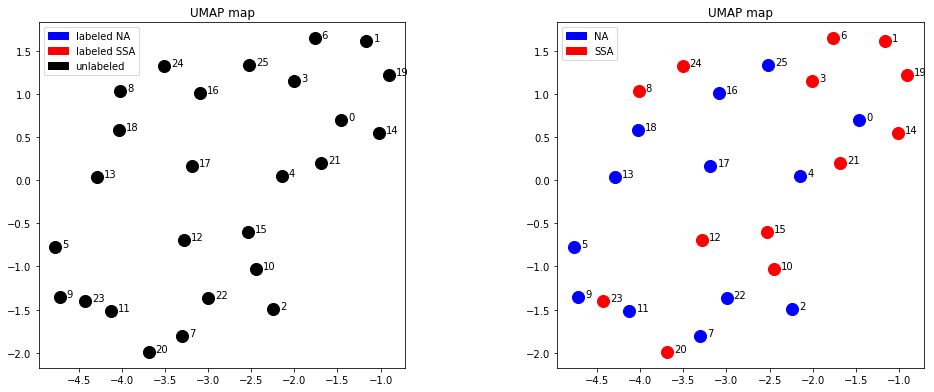

In [164]:
#import sys
#!{sys.executable} -m pip install umap-learn==0.3.10
import umap.umap_ as umap

def computeUMAPCoordinate(distance_matrix,sslLabel,n_pcoa_comp=2):
    #points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed',printStress=True)
    points = computePCoACoordinate(distance_matrix,n_pcoa_comp)

    fitter = umap.UMAP(n_neighbors=4).fit(points, y=sslLabel)
    embedding = fitter.embedding_
    return embedding
    
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
# -1 for unlabeled data
try:
    sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)
except:
    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)
points = computeUMAPCoordinate(distance_matrix,sslLabel,6)
plotPoints(points,title='UMAP map')

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')

for i in range(len(condition)):
    ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))

plt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')
plt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')
plt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')

NA = mpatches.Patch(color='blue', label='labeled NA')
SSA = mpatches.Patch(color='red', label='labeled SSA')
unlabeled = mpatches.Patch(color='black', label='unlabeled')

plt.legend(handles=[NA,SSA,unlabeled])
plt.title('UMAP map')

'''
## Compare to MDS

plotPoints(points,title='MDS map')

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')

for i in range(len(condition)):
    ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))

plt.scatter(points[sslLabel==0,0],points[sslLabel==0,1],color='blue',s=145,label='NA')
plt.scatter(points[sslLabel==1,0],points[sslLabel==1,1],color='red',s=145,label='SSA')
plt.scatter(points[sslLabel==-1,0],points[sslLabel==-1,1],color='black',s=145,label='unlabeled')

NA = mpatches.Patch(color='blue', label='labeled NA')
SSA = mpatches.Patch(color='red', label='labeled SSA')
unlabeled = mpatches.Patch(color='black', label='unlabeled')

plt.legend(handles=[NA,SSA,unlabeled])
plt.title('MDS map')
'''

## DBSCAN (here with option "precomputed metric" -> array of distances)

In [165]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
db = DBSCAN(eps=1, min_samples=1,metric='precomputed').fit(distance_matrix)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 25


pcoa proportion explained : 0.2943408159201289 


//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -18.530260164118374 and the largest is 103.66754144205802.
  RuntimeWarning


no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot


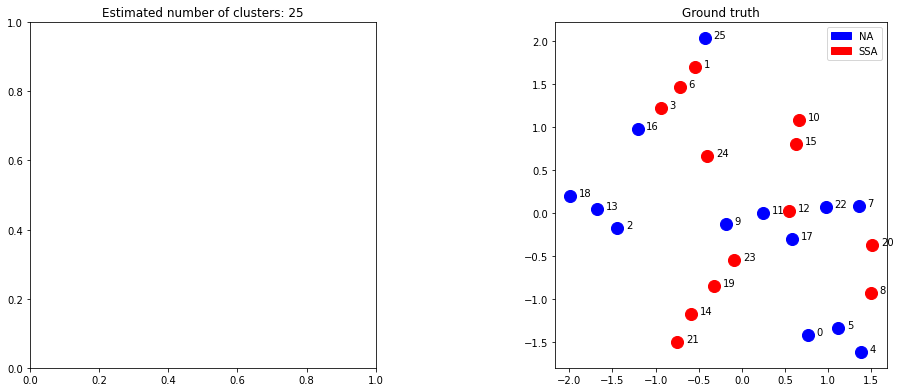

In [166]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
#points,stress = computeMDSCoordinate(distance_matrix,mdsDim,dissimilarity='precomputed')
#points_lessD = transformPoints(points)
points = computeSNECoordinate(distance_matrix)

for k, col in zip(unique_labels, colors):

    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = points[class_member_mask & core_samples_mask]
    try:
        plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
    except:
        print("no plot")
    xy = points[class_member_mask & ~core_samples_mask]
    try:
        plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    except:
        print("no plot")
        
plt.title('Estimated number of clusters: %d' % n_clusters_)

# Compare to ground truth
plotPoints(points,projection=True)

## Mean Shift (to do on coordinates)

//anaconda3/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -18.530260164118374 and the largest is 103.66754144205802.
  RuntimeWarning


pcoa proportion explained : 0.2943408159201289 
number of estimated clusters : 2


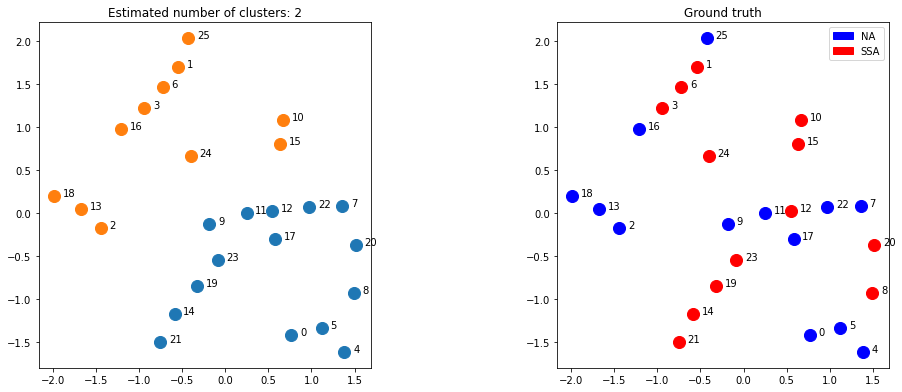

In [167]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Compute clustering with MeanShift
distance_matrix = computeDistanceMatrix(norm_coef,addCoef=add_coef)
points = computeSNECoordinate(distance_matrix)

# Compare to ground truth
plotPoints(points,projection=True)

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(points, quantile=0.35) # 0.35 : heuristically found to have 2 clusters

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result
from itertools import cycle

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
#points = transformPoints(points)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    ax.scatter(points[my_members, 0], points[my_members, 1], s=145)
    
    subjects = np.arange(0,N)
    for i in subjects[my_members==1]:
        ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+np.max(points)/20,points[i,1]))
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)

## 2-cluster methods

### K-Means

In [181]:
from sklearn.cluster import KMeans

nRun = 10
random_init = True
mds_random_init = True # MDS with several random init
nMDSRun = 100 # Number of mds runs with different random init if mds_random_init True
compute = True

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    kmeans_result = MapMethodResults("k-means",random_init)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            kmeans = KMeans(n_clusters=2,n_init=1)
            kmeans_result.applyMethodAndMDSAverages(kmeans,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            kmeans = KMeans(n_clusters=2,n_init=1)
            kmeans_result.applyMethodAverage(kmeans,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        # kmeans = KMeans(n_clusters=2,n_init=1) # init array used before fit
        kmeans = KMeans(n_clusters=2,n_init=100)
        kmeans_result.applyMethod(kmeans,dim=[2]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


Results

Found clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
True clusters 
[0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Wrong classified
[]
Best k-means accuracy : 1.000000
Silhouette coefficient : 0.013
Robust participants
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[]
Frequencies
[0.435 0.603 0.404 0.607 0.424 0.421 0.588 0.401 0.579 0.396 0.586 0.448
 0.547 0.42  0.566 0.596 0.412 0.435 0.431 0.581 0.564 0.556 0.39  0.528
 0.599 0.427]
DB index : 3.149159 


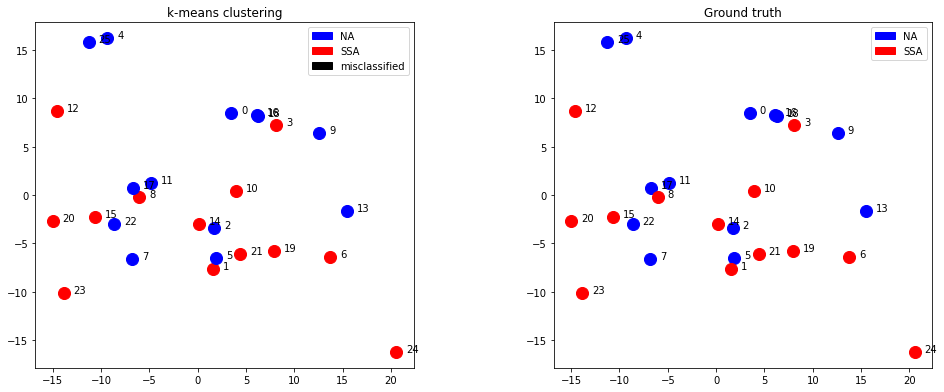

In [182]:
# Show results

if (compute):
    if (random_init==False):
        kmeans_result.clusteringAccuracyWithDimension()
    kmeans_result.twoClustersMethodResult()
    kmeans_result.showResultMap()
    plotPoints(kmeans_result.best_points)
    #plt.scatter(kmeans.init[:,0],kmeans.init[:,1],s=200,marker='x') # if t-SNE and 1 coef
    print("DB index : %f " %kmeans_result.dbScore())
    kmeans_result.writeProbaLabel()
    if 'k-means' not in methodUsed:
        accuracyVect = np.append(accuracyVect,kmeans_result.best_accuracy)
        SCVect = np.append(SCVect,kmeans_result.SC)
        methodUsed = np.append(methodUsed,'k-means')
        prior = np.append(prior,('t-SNE')*(kmeans_result.best_dim==7)+('PCoA '+str(abs(dim)))*(kmeans_result.best_dim<0)+('MDS '+str(dim))*(kmeans_result.best_dim<7)*(kmeans_result.best_dim>0))


### Spectral Clustering

In [170]:
from sklearn.cluster import SpectralClustering

compute = False

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    spectralClustering_result = MapMethodResults("spectral clustering",random_init)
    gamma = 1
    if (random_init): # Make several runs
        if (mds_random_init): # MDS        
            spectralClustering = SpectralClustering(n_clusters=2,n_init=1,gamma=gamma)
            #[ 1  3  6  8 10 16]
            spectralClustering_result.applyMethodAndMDSAverages(spectralClustering,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else: # PCoA or t-SNE
            spectralClustering = SpectralClustering(n_clusters=2,n_init=1,gamma=gamma)
            spectralClustering_result.applyMethodAverage(spectralClustering,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        spectralClustering = SpectralClustering(n_clusters=2, n_init=1000,gamma=gamma)
        spectralClustering_result.applyMethod(spectralClustering,dim=[1,2,7]) # 2D max I think, otherwise curse of dimensionnality

In [171]:
# Show results

if (compute):
    if (random_init==False):
        spectralClustering_result.clusteringAccuracyWithDimension()
    spectralClustering_result.twoClustersMethodResult()
    spectralClustering_result.showResultMap()
    plotPoints(spectralClustering_result.best_points)
    print("DB index : %f " %spectralClustering_result.dbScore())
    spectralClustering_result.writeProbaLabel()
    if 'SC_map' not in methodUsed:
        accuracyVect = np.append(accuracyVect,spectralClustering_result.best_accuracy)
        SCVect = np.append(SCVect,spectralClustering_result.SC)
        methodUsed = np.append(methodUsed,'SC_map')
        prior = np.append(prior,('t-SNE')*(spectralClustering_result.best_dim==7)+('PCoA '+str(abs(dim)))*(spectralClustering_result.best_dim<0)+('MDS '+str(dim))*(spectralClustering_result.best_dim<7)*(spectralClustering_result.best_dim>0))
        

### GMM

In [172]:
from sklearn.mixture import GaussianMixture

compute = False

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    gmm_result = MapMethodResults("gaussian mixture",random_init)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            gmm = GaussianMixture(n_components=2,n_init=1)
            gmm_result.applyMethodAndMDSAverages(gmm,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            gmm = GaussianMixture(n_components=2,n_init=1)
            gmm_result.applyMethodAverage(gmm,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        gmm = GaussianMixture(n_components=2, n_init=1000)
        gmm_result.applyMethod(gmm,dim=[1,2,7]) # 2D max I think, otherwise curse of dimensionnality

In [173]:
# Show results

if (compute):
    if (random_init==False):
        gmm_result.clusteringAccuracyWithDimension()
    gmm_result.twoClustersMethodResult()
    gmm_result.showResultMap()
    plotPoints(gmm_result.best_points)
    print("DB index : %f " %gmm_result.dbScore())
    gmm_result.writeProbaLabel()
    if 'GMM' not in methodUsed:
        accuracyVect = np.append(accuracyVect,gmm_result.best_accuracy)
        SCVect = np.append(SCVect,gmm_result.SC)
        methodUsed = np.append(methodUsed,'GMM')
        prior = np.append(prior,('t-SNE')*(gmm_result.best_dim==7)+('PCoA '+str(abs(dim)))*(gmm_result.best_dim<0)+('MDS '+str(dim))*(gmm_result.best_dim<7)*(gmm_result.best_dim>0))


## Semi-supervised learning (SSL)

### Label propagation

In [174]:
from sklearn.semi_supervised import LabelPropagation

compute = True
mds_random_init = False

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    # -1 for unlabeled data
    '''
    try:
        sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)
    except:
        sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)
    '''
    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)
    
    labelPropagation_result = MapMethodResults("Label propagation",random_init,sslLabel=sslLabel)
    if (mds_random_init): # Make several MDS runs
        labelPropagation = LabelPropagation(n_neighbors=4,max_iter=10000)
        labelPropagation_result.applyMethodAndMDSAverages(labelPropagation,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        labelPropagation = LabelPropagation(n_neighbors=4,max_iter=10000)
        labelPropagation_result.applyMethod(labelPropagation,dim=[1,2,7]) # 2D max I think, otherwise curse of dimensionnality

Computing clustering

0%


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
# Show results

if (compute):
    if (random_init==False):
        labelPropagation_result.clusteringAccuracyWithDimension()
    labelPropagation_result.twoClustersMethodResult()
    labelPropagation_result.showResultMap()
    plotPoints(labelPropagation_result.best_points)
    print("DB index : %f " %labelPropagation_result.dbScore())
    # kmeans robust [ 0  4  5  6  9 11 12 13 19 21 22 23 24]
    if 'label propagation' not in methodUsed:
        accuracyVect = np.append(accuracyVect,labelPropagation_result.best_accuracy)
        SCVect = np.append(SCVect,labelPropagation_result.SC)
        methodUsed = np.append(methodUsed,'label propagation')
        prior = np.append(prior,('t-SNE')*(labelPropagation_result.best_dim==7)+('PCoA '+str(dim))*(labelPropagation_result.best_dim<7))    

### Label spreading

In [ ]:
from sklearn.semi_supervised import LabelSpreading

compute = True

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    # -1 for unlabeled data
    '''
    try:
        sslLabel = (kmeans_result.robustLabel)*(kmeans_result.label)-1*(kmeans_result.robustLabel==0)
    except:
        sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)
    '''
    sslLabel = (kmedoids_result.robustLabel)*(kmedoids_result.label)-1*(kmedoids_result.robustLabel==0)
    
    labelSpreading_result = MapMethodResults("Label spreading",random_init,sslLabel=sslLabel)
    if (mds_random_init): # Make several MDS runs
        labelSpreading = LabelSpreading(n_neighbors=4,max_iter=10000)
        labelSpreading_result.applyMethodAndMDSAverages(labelSpreading,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        labelSpreading = LabelSpreading(n_neighbors=4,max_iter=10000)
        labelSpreading_result.applyMethod(labelSpreading,dim=[1,2,7]) # 2D max I think, otherwise curse of dimensionnality

In [ ]:
# Show results

if (compute):
    if (random_init==False):
        labelSpreading_result.clusteringAccuracyWithDimension()
    labelSpreading_result.twoClustersMethodResult()
    labelSpreading_result.showResultMap()
    plotPoints(labelSpreading_result.best_points)
    print("DB index : %f " %labelSpreading_result.dbScore())
    # kmeans robust [ 0  4  5  6  9 11 12 13 19 21 22 23 24]
    if 'label spreading' not in methodUsed:
        accuracyVect = np.append(accuracyVect,labelSpreading_result.best_accuracy)
        SCVect = np.append(SCVect,labelSpreading_result.SC)
        methodUsed = np.append(methodUsed,'label spreading')
        prior = np.append(prior,('t-SNE')*(labelSpreading_result.best_dim==7)+('PCoA '+str(dim))*(labelSpreading_result.best_dim<7))    

### COP-Kmeans

In [ ]:
def makePairs(arr, n): 
    # Set to store unique pairs 
    s = []
  
    # Make all possible pairs 
    for i in range(n): 
        for j in range(i+1,n): 
            s.append((arr[i], arr[j]))
  
    return s

must_link0 = subjects[sslLabel==0]
print(must_link0)
must_link0 = makePairs(must_link0, len(must_link0))

must_link1 = subjects[sslLabel==1]
print(must_link1)
must_link1 = makePairs(must_link1, len(must_link1))

must_link = must_link0 + must_link1
print(must_link)

cannot_link = []
for i in range(len(subjects[sslLabel==1])):
    for j in range(len(subjects[sslLabel==0])):
        cannot_link.append((subjects[sslLabel==1][i],subjects[sslLabel==0][j]))

print(cannot_link)

In [ ]:
from COPKmeans import COPKmeans

compute = True
mds_random_init = True
random_init = True
nRun = 10
nMDSRun = 100

if (compute):
    # coefficients = np.linspace(1,45,2)
    coefficients = [45] # Changing normalisation coefficient does not change mapping if add_coef large enough 
                        # (2 is ok for that and for only positive eigen values EEG)

    copkmeans_result = MapMethodResults("COP-Kmeans",random_init)
    if (random_init): # Make several runs
        if (mds_random_init): # MDS  
            copkmeans = COPKmeans(n_clusters=2,must_link=must_link,cannot_link=cannot_link)
            copkmeans_result.applyMethodAndMDSAverages(copkmeans,dim=2,coef=norm_coef,n_run=nRun,n_mds_run=nMDSRun) # 2D max I think, otherwise curse of dimensionnality
        else:
            copkmeans = COPKmeans(n_clusters=2,must_link=must_link,cannot_link=cannot_link)
            copkmeans_result.applyMethodAverage(copkmeans,dim=2,coef=norm_coef,n_run=nRun) # 2D max I think, otherwise curse of dimensionnality
    else: # Compare effect of normalization and dimension
        # copkmeans = COPKmeans(n_clusters=2,n_init=1) # init array used before fit
        copkmeans = COPKmeans(n_clusters=2)
        copkmeans_result.applyMethod(copkmeans,must_link=must_link,cannot_link=cannot_link,dim=[1,2,7]) # 2D max I think, otherwise curse of dimensionnality

In [ ]:
# Show results

if (compute):
    if (random_init==False):
        copkmeans_result.clusteringAccuracyWithDimension()
    copkmeans_result.twoClustersMethodResult()
    copkmeans_result.showResultMap()
    plotPoints(copkmeans_result.best_points)
    #plt.scatter(copkmeans.init[:,0],copkmeans.init[:,1],s=200,marker='x') # if t-SNE and 1 coef
    print("DB index : %f " %copkmeans_result.dbScore())
    if 'COP-Kmeans' not in methodUsed:
        accuracyVect = np.append(accuracyVect,copkmeans_result.best_accuracy)
        SCVect = np.append(SCVect,copkmeans_result.SC)
        methodUsed = np.append(methodUsed,'COP-Kmeans')
        prior = np.append(prior,('t-SNE')*(copkmeans_result.best_dim==7)+('PCoA '+str(dim))*(copkmeans_result.best_dim<7))

## Comparing accuracy and silhouette coefficient

In [ ]:
for meth in np.unique(prior):
    plt.scatter(accuracyVect[prior==meth],SCVect[prior==meth],label=meth) # Hard to compare MDS results because of random init

plt.xlabel("accuracy")
plt.ylabel("silhouette coefficient")
plt.legend()
plt.show()